In [2]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from scipy.stats import chi2_contingency


Paths

In [3]:
field_types_file = r'utilfiles/codes_after_reduction.csv'
trn_rd_path = r'utilfiles/train_reduced_ukb672220.csv'
trn_data = r'~/Project/PlayGround/train_set_after_handling_dataTypes_and_nulls.csv'

Load Datafields types table and save each type in list

In [4]:
field_types_df = pd.read_csv(field_types_file)

# Create a dictionary with field names as keys and field types as values
field_types = dict(zip(field_types_df['codes'], field_types_df['dataType']))

# Separate fields based on their types
categorical_single_fields = [field for field, dtype in field_types.items() if dtype == 'Categorical (single)']
categorical_multiple_fields = [field for field, dtype in field_types.items() if dtype == 'Categorical (multiple)']
numerical_fields = [field for field, dtype in field_types.items() if dtype == 'Integer']
continuous_fields = [field for field, dtype in field_types.items() if dtype == 'Continuous']
# date_fields = [field for field, dtype in field_types.items() if dtype == 'Date']

categorical_original_fields = categorical_single_fields + categorical_multiple_fields # + date_fields

Support functions

In [5]:
def contains_any(target_string ,prefixes):
    for prefix in prefixes:
        if target_string.startswith(prefix):
            return True
    return False

def find_original_code(target_string,prefixes):
    for prefix in prefixes:
        if target_string.startswith(prefix):
            return prefix
    

Save Categoric fields in list

In [6]:
cols = pd.read_csv(trn_data,nrows=1).columns.to_list()
categorical_fields = []
for col in tqdm(cols):
    if contains_any(col, categorical_original_fields):
        categorical_fields.append(col)

100%|██████████| 513/513 [00:00<00:00, 194317.52it/s]


Run SelectKBest With Chi2

In [7]:
trn_sample_OneHot_file_path = r'utilfiles/trn_sample_OneHot.csv'
trn_sample_NoOneHot_file_path = r'utilfiles/trn_sample_NoOneHot.csv'

trn_file_path = trn_sample_NoOneHot_file_path # change to trn_sample_OneHot_file_path or trn_sample_NoOneHot_file_path by demand

if trn_file_path == trn_sample_OneHot_file_path:
    pass # prev cell handle it
elif trn_file_path == trn_sample_NoOneHot_file_path:
    categorical_fields = categorical_original_fields
X_train = pd.read_csv(trn_file_path,usecols=categorical_fields)
y_train = pd.read_csv(trn_file_path)['target']


In [8]:
# Create an Imputer  object
imputer = SimpleImputer(strategy='constant', 
                        fill_value=-3)

# Fit and transform the training data
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train),columns=X_train.columns).astype(int)

In [9]:
# Use LabelEncoder handle encoding values.
labelEncoders = {}
for col in X_train_imputed.columns:
    le = LabelEncoder()
    X_train_imputed[col] = le.fit_transform(X_train_imputed[col])
    labelEncoders[col] = le

X_train_final = X_train_imputed

# Apply SelectKBest
fs = SelectKBest(score_func=chi2, k='all')
X_train_fs = fs.fit_transform(X_train_final, y_train)

In [10]:
feature_names_df = pd.read_csv(r'utilfiles/codes_after_reduction.csv')

feature_name_map = pd.Series(feature_names_df.description.values, index=feature_names_df.codes).to_dict()

def convert_feature_code_to_name(feature_code):
    code_founded = find_original_code(feature_code,categorical_original_fields)
    return feature_name_map.get(code_founded, code_founded) + ' - ' + code_founded

In [11]:
# Get the scores for each feature
feature_scores = fs.scores_

# Create a DataFrame to view feature scores
feature_scores_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Score': feature_scores
})

feature_scores_df['Real Feature Name'] = feature_scores_df['Feature'].apply(convert_feature_code_to_name)

# Sort the DataFrame by score
feature_scores_df = feature_scores_df.sort_values(by='Score', ascending=False)

print(feature_scores_df.head(25))  # Top 40 features


      Feature        Score                                  Real Feature Name
49   2415-0.0  2728.515162                    Had major operations - 2415-0.0
53   2844-0.0  2198.333440              Had other major operations - 2844-0.0
26   1249-0.0   607.993707                    Past tobacco smoking - 1249-0.0
3     806-0.0   522.167987  Job involves mainly walking or standing - 806-0.0
10    991-0.0   463.217543  Frequency of strenuous sports in last 4 weeks ...
11   1001-0.0   443.894512            Duration of strenuous sports - 1001-0.0
66   6154-0.0   409.557271  Medication for pain relief, constipation, hear...
5     826-0.0   394.144753                  Job involves shift work - 826-0.0
9     981-0.0   333.550727            Duration walking for pleasure - 981-0.0
4     816-0.0   324.676172  Job involves heavy manual or physical work - 8...
2     738-0.0   301.825261  Average total household income before tax - 73...
71  20533-0.0   267.361400                 Trouble falling aslee

In [12]:
def Plot_barh_results(df, y_axis_feature,x_axis_feature, k=100, NameOfTesting=None, figsize = (20,10), color='skyblue'):
# Plot the top 10 features
    top_features = df.head(k)

    plt.figure(figsize=figsize)
    plt.barh(top_features[y_axis_feature], top_features[x_axis_feature], color=color)
    plt.xlabel('Score')
    plt.ylabel('Feature')
    plt.title(f'Top {k} Important Features {f"In {NameOfTesting}" if NameOfTesting else ""}')
    plt.gca().invert_yaxis()
    plt.show()


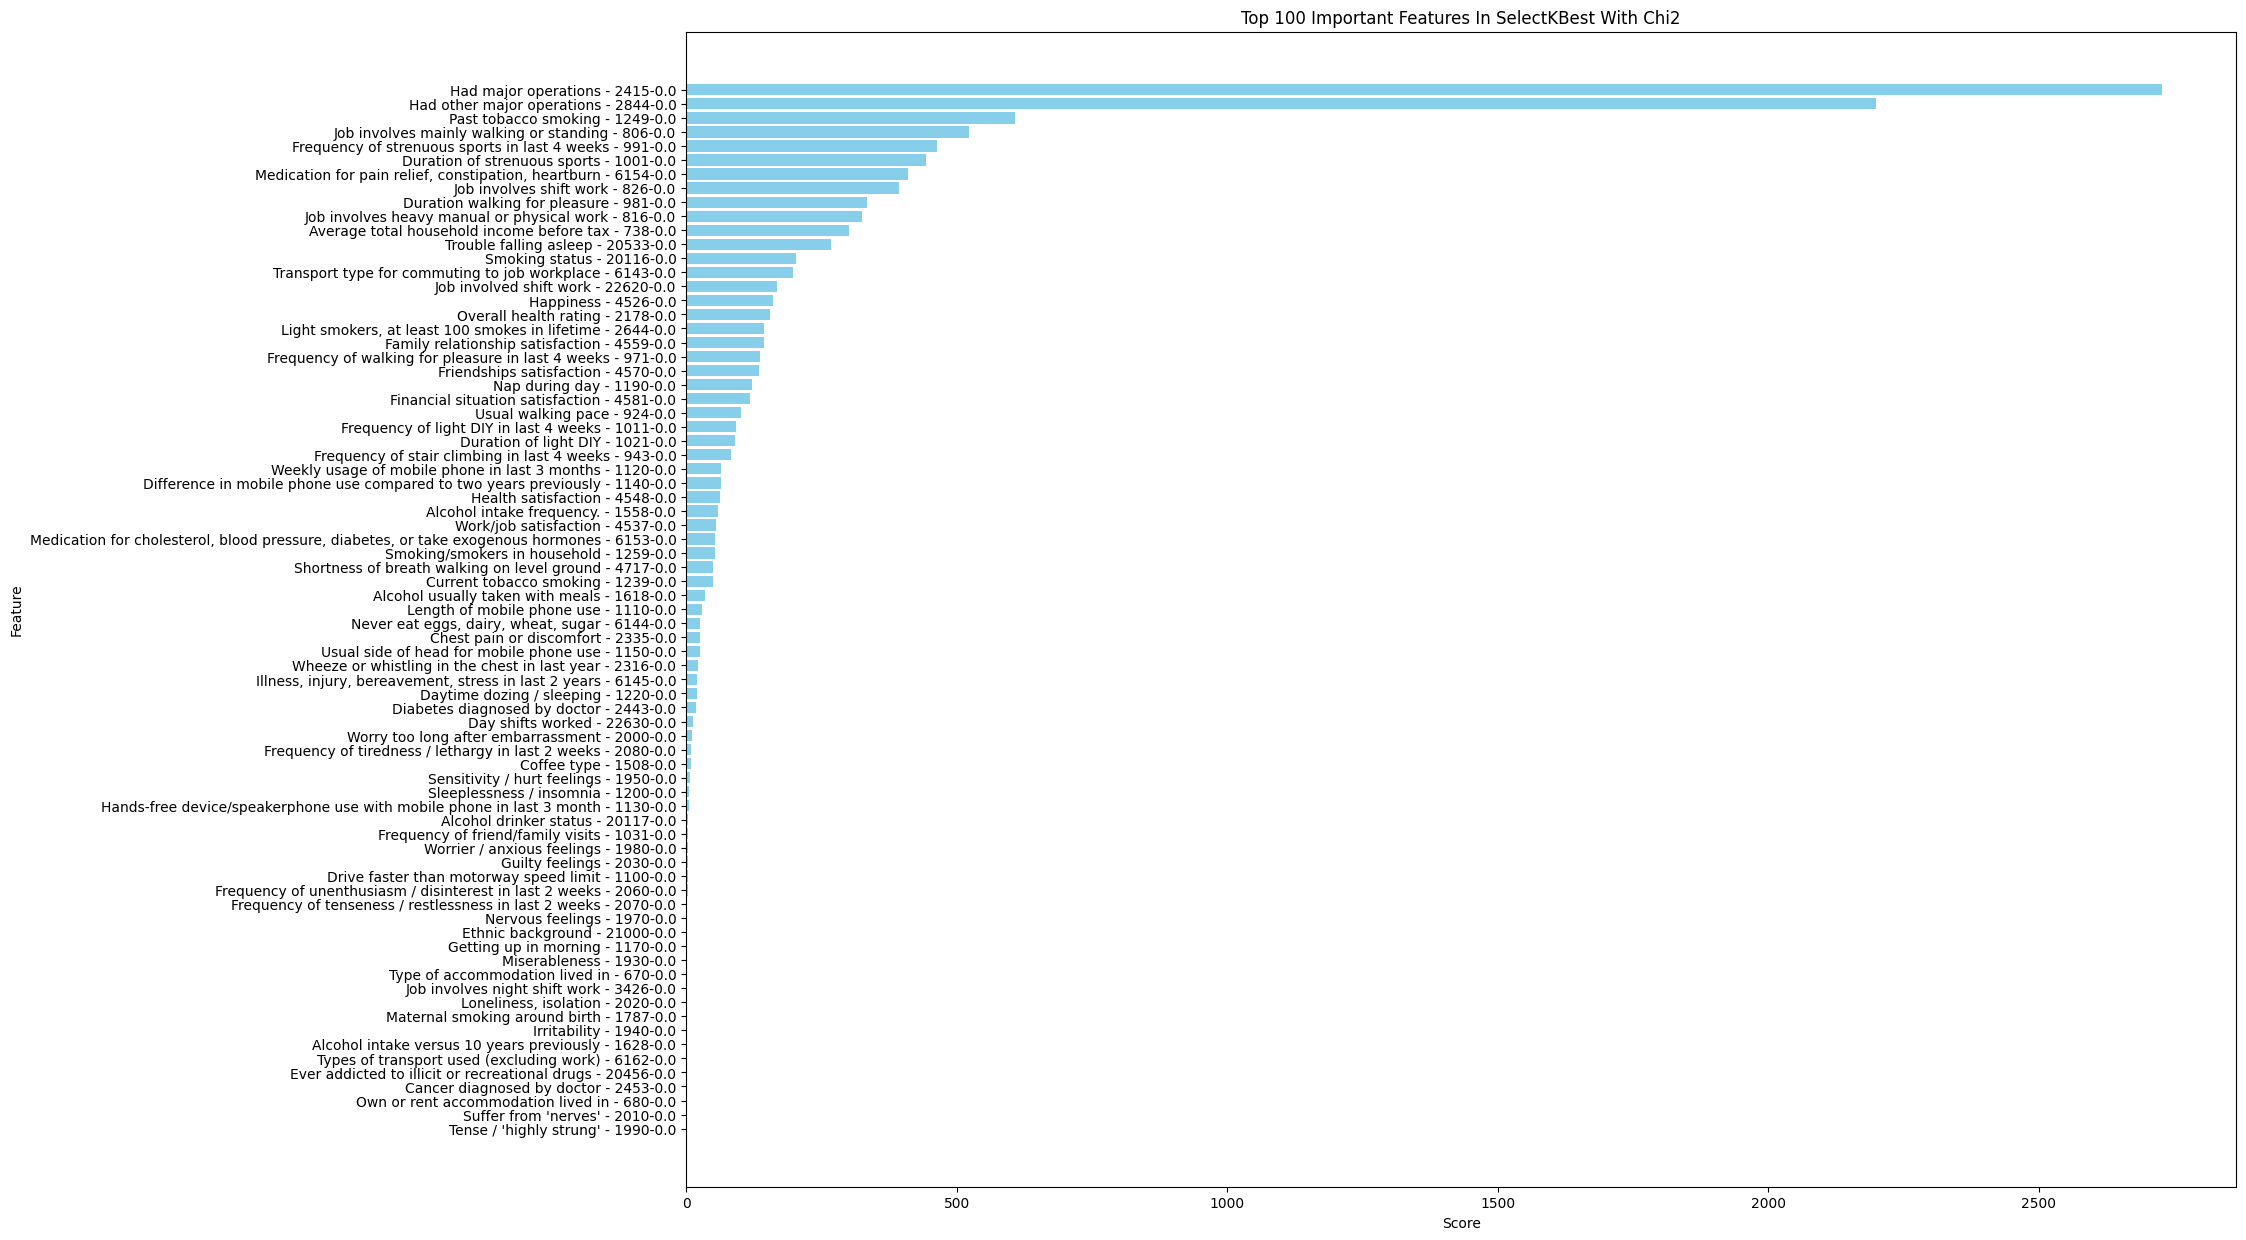

In [13]:
Plot_barh_results(df=feature_scores_df,
                  y_axis_feature= 'Real Feature Name',
                  x_axis_feature= 'Score', 
                  k=100,
                  NameOfTesting='SelectKBest With Chi2',
                  figsize=(20,15))

In [14]:
feature_scores_df

,Feature,Score,Real Feature Name
49,2415-0.0,2728.515162,Had major operations - 2415-0.0
53,2844-0.0,2198.333440,Had other major operations - 2844-0.0
26,1249-0.0,607.993707,Past tobacco smoking - 1249-0.0
3,806-0.0,522.167987,Job involves mainly walking or standing - 806-0.0
10,991-0.0,463.217543,Frequency of strenuous sports in last 4 weeks ...
...,...,...,...
70,20456-0.0,0.107690,Ever addicted to illicit or recreational drugs...
51,2453-0.0,0.045601,Cancer diagnosed by doctor - 2453-0.0
1,680-0.0,0.017936,Own or rent accommodation lived in - 680-0.0
40,2010-0.0,0.001622,Suffer from 'nerves' - 2010-0.0


In [15]:
def make_chi2_test_and_print(X_train_final, y_train, labelEncoders,feature, i=None):

    original_values_top_feature = labelEncoders[feature].inverse_transform(X_train_final[feature])

    contingency_table = pd.crosstab(original_values_top_feature,y_train)

    chi2_, p , dof, ex = chi2_contingency(contingency_table)

    contingency_table = contingency_table.astype(int)

    expected_table = pd.DataFrame(ex,
                                  index=contingency_table.index, 
                                  columns=contingency_table.columns)

    if i != None and i != 1:
        print("\n\n-----------------------------------------------------------------\n")
    print(f'Feature: {convert_feature_code_to_name(feature)} {f"Ranked {i}" if i != None else ""}')

    print("\nObserved:")
    print(contingency_table)
    print("\nExpected:")
    print(expected_table)
    print(f"\nChi2 Statistics: {chi2_}")
    print(f"\np-value: {p}")

    contribution = (contingency_table - expected_table) ** 2 / expected_table

    print("\nContribution to Chi2 Statistic:")
    print(contribution)

In [16]:
# Print Chi2 Test For each feature

for i, feature in enumerate(feature_scores_df['Feature'].to_list()):
    make_chi2_test_and_print(X_train_final, y_train, labelEncoders,feature, i+1)

Feature: Had major operations - 2415-0.0 Ranked 1

Observed:
target      0     1
row_0              
-3      21565  3044
-1        139    61
 0       6461  2091
 1      10495  4469

Expected:
target        0       1
row_0                  
-3      19687.2  4921.8
-1        160.0    40.0
 0       6841.6  1710.4
 1      11971.2  2992.8

Chi2 Statistics: 1925.3555110857683

p-value: 0.0

Contribution to Chi2 Statistic:
target           0           1
row_0                         
-3      179.107889  716.431558
-1        2.756250   11.025000
 0       21.172878   84.691511
 1      182.034085  728.136341


-----------------------------------------------------------------

Feature: Had other major operations - 2844-0.0 Ranked 2

Observed:
target      0     1
row_0              
-3      17244  6659
-1        165    30
 0       7175   747
 1      14076  2229

Expected:
target        0       1
row_0                  
-3      19122.4  4780.6
-1        156.0    39.0
 0       6337.6  1584.4
 1     



-----------------------------------------------------------------

Feature: Overall health rating - 2178-0.0 Ranked 17

Observed:
target      0     1
row_0              
-3        100    33
-1        174    55
 1       6569   964
 2      22400  4959
 3       7847  2764
 4       1570   890

Expected:
target        0       1
row_0                  
-3        106.4    26.6
-1        183.2    45.8
 1       6026.4  1506.6
 2      21887.2  5471.8
 3       8488.8  2122.2
 4       1968.0   492.0

Chi2 Statistics: 953.6454630362657

p-value: 6.513037499733962e-204

Contribution to Chi2 Statistic:
target          0           1
row_0                        
-3       0.384962    1.539850
-1       0.462009    1.848035
 1      48.854168  195.416673
 2      12.014503   48.058014
 3      48.523612  194.094449
 4      80.489837  321.959350


-----------------------------------------------------------------

Feature: Light smokers, at least 100 smokes in lifetime - 2644-0.0 Ranked 18

Observed:
target

## **Check SelectKBest With mutual_info_classif**

In [17]:
from sklearn.feature_selection import mutual_info_classif

In [18]:
vld_file_path = r'utilfiles/vld_without_onehot.csv'

In [19]:
def select_feature_mic(X_train, y_train, X_test, k='all'):
    fs = SelectKBest(score_func=mutual_info_classif, k=k)
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

Prepare Validation Test

In [20]:
X_validation = pd.read_csv(vld_file_path,usecols=categorical_fields)
y_validation = pd.read_csv(vld_file_path)['target']

In [21]:
# Create an Imputer  object
imputer = SimpleImputer(strategy='constant', 
                        fill_value=-3)

# Fit and transform the training data
X_validation_imputed = pd.DataFrame(imputer.fit_transform(X_validation),
                               columns=X_validation.columns
                               ).astype(int)
# Use LabelEncoder handle encoding values.
labelEncoders_vld = {}
for col in X_validation_imputed.columns:
    le = LabelEncoder()
    X_validation_imputed[col] = le.fit_transform(X_validation_imputed[col])
    labelEncoders_vld[col] = le

X_validation_final = X_validation_imputed

### Run SelectKBest With mutual_info_classif 

In [22]:
# Apply SelectKBest
X_train_fs, X_validation_fs, fs = select_feature_mic(X_train_final, y_train, X_validation_final)

##### Prepare Data for plot results

      Feature     Score                                  Real Feature Name
65   6153-0.0  0.027172  Medication for cholesterol, blood pressure, di...
53   2844-0.0  0.024286              Had other major operations - 2844-0.0
49   2415-0.0  0.021471                    Had major operations - 2415-0.0
46   2178-0.0  0.013703                   Overall health rating - 2178-0.0
66   6154-0.0  0.013257  Medication for pain relief, constipation, hear...
27   1259-0.0  0.012418            Smoking/smokers in household - 1259-0.0
68  20116-0.0  0.012097                         Smoking status - 20116-0.0
25   1239-0.0  0.011361                 Current tobacco smoking - 1239-0.0
6     924-0.0  0.011085                       Usual walking pace - 924-0.0
72  21000-0.0  0.010321                      Ethnic background - 21000-0.0
26   1249-0.0  0.010151                    Past tobacco smoking - 1249-0.0
50   2443-0.0  0.010114            Diabetes diagnosed by doctor - 2443-0.0
69  20117-0.0  0.009960  

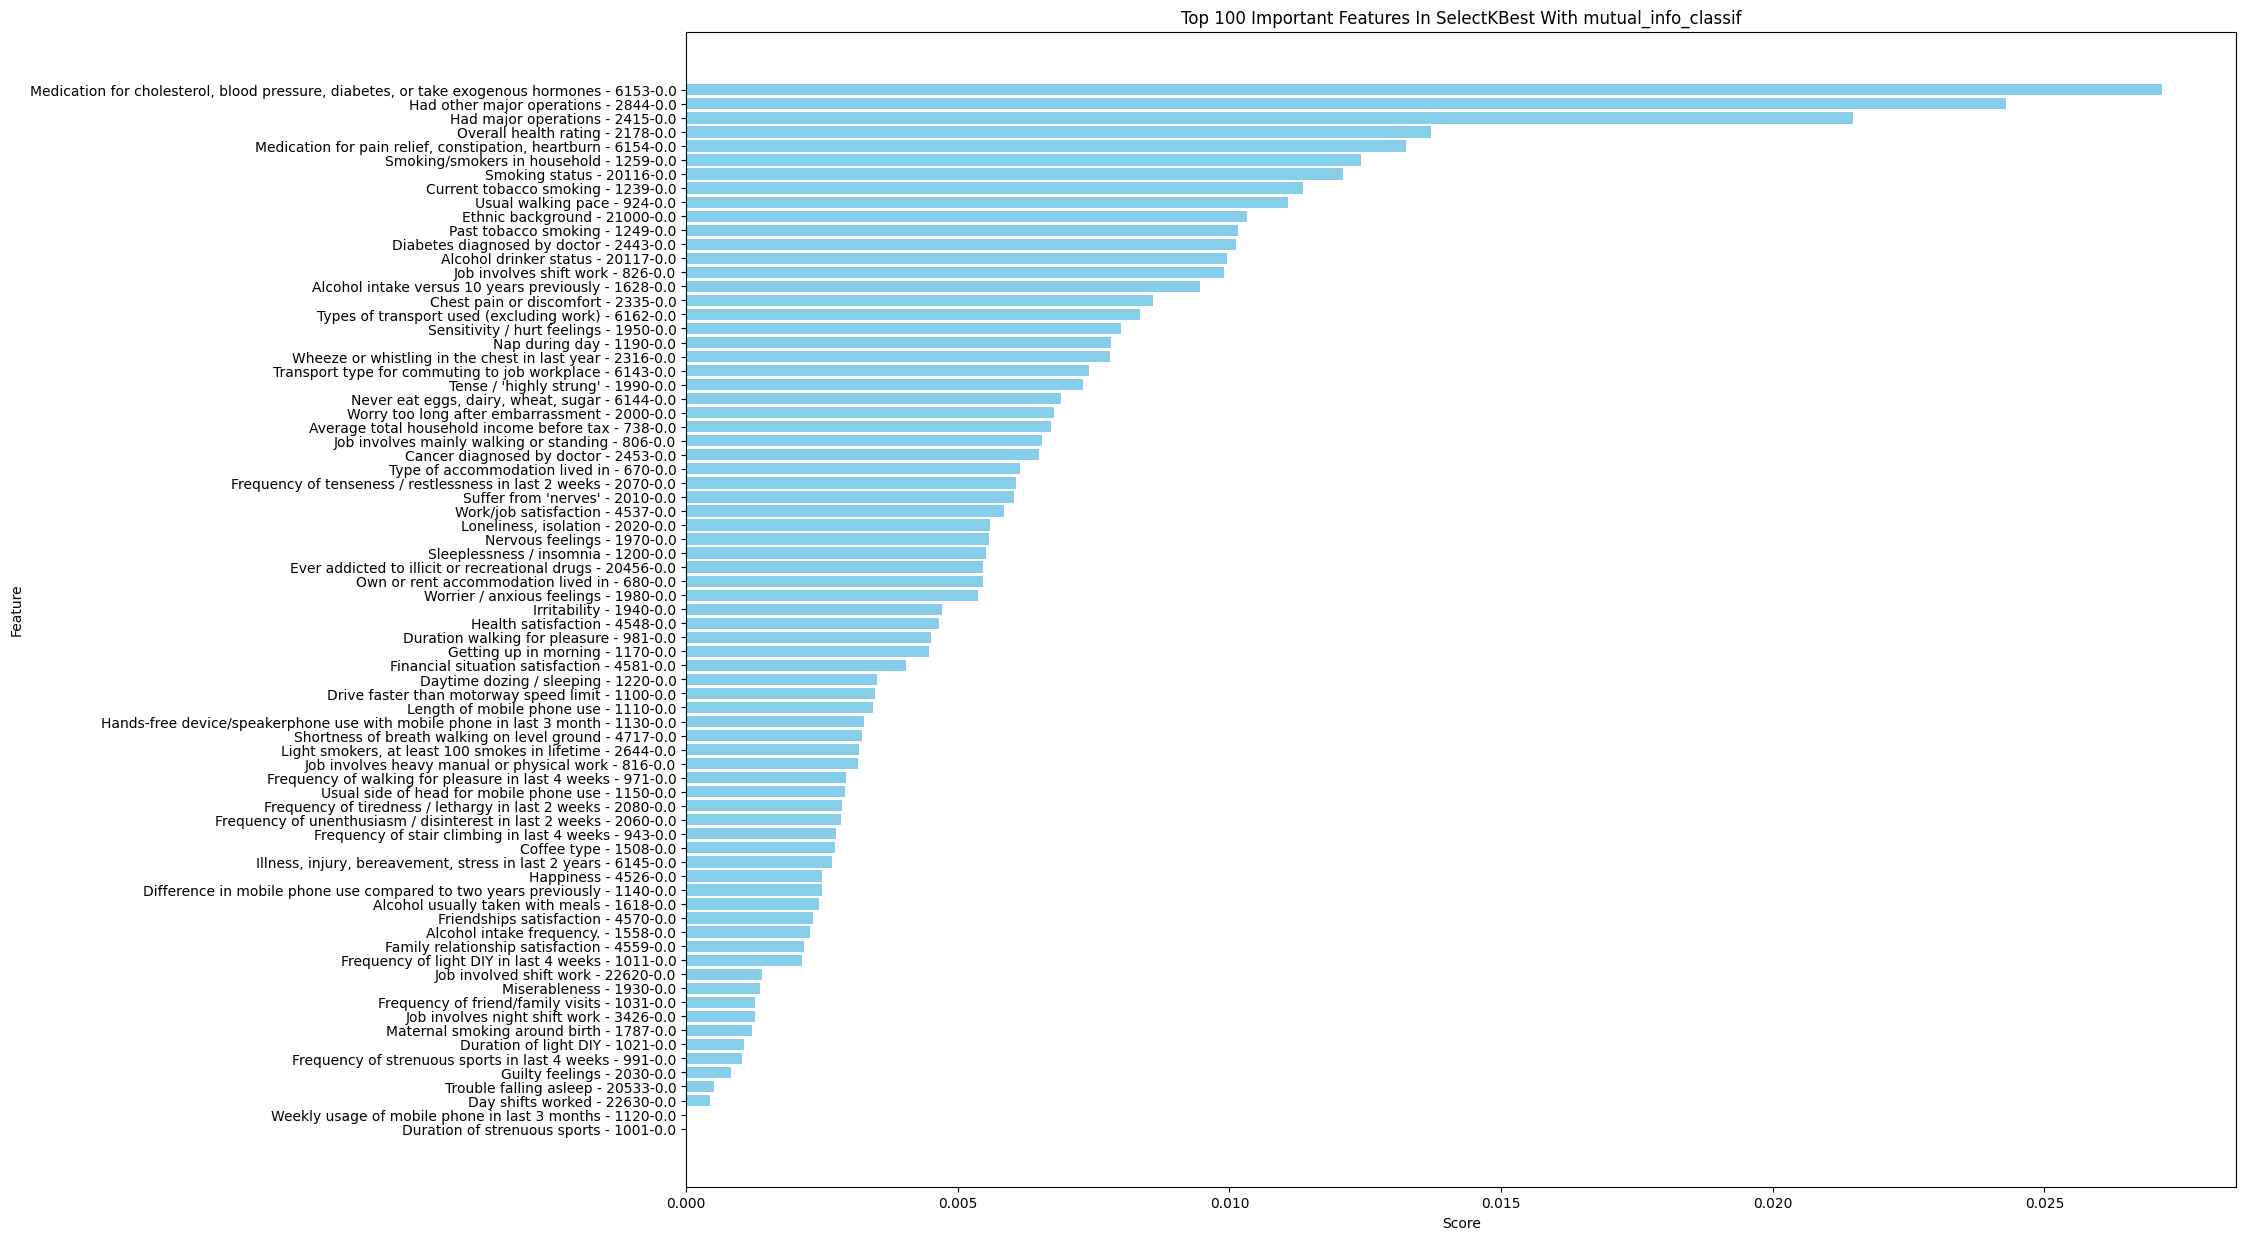

In [23]:
# Get the scores for each feature
feature_scores = fs.scores_

# Create a DataFrame to view feature scores
feature_scores_df = pd.DataFrame({
    'Feature': X_train_final.columns,
    'Score': feature_scores
})

feature_scores_df['Real Feature Name'] = feature_scores_df['Feature'].apply(convert_feature_code_to_name)

# Sort the DataFrame by score
feature_scores_df = feature_scores_df.sort_values(by='Score', ascending=False)

print(feature_scores_df.head(25))  # Top 25 features

Plot_barh_results(df=feature_scores_df,
                  y_axis_feature= 'Real Feature Name',
                  x_axis_feature= 'Score', 
                  k=100,
                  NameOfTesting='SelectKBest With mutual_info_classif',
                  figsize=(20,15))

### Check Data with Factor Analysis

In [24]:
# TODO: Explore it

from sklearn.decomposition import FactorAnalysis

fa = FactorAnalysis(n_components=10)
X_fa = fa.fit_transform(X_train_final, y_train)

# Display the explained variance ratio
print(fa.components_)

[[-3.61801638e-02 -7.72876184e-02  8.36101531e-02 -3.59103117e-03
  -1.59634588e-02  2.58141675e-03  4.29014346e-02  9.00303276e-02
   1.49224923e-01  2.06997509e-01  7.23013135e-02  7.19518122e-02
   1.02004789e-01  7.08258599e-02 -3.68563488e-03 -4.04158927e-02
  -3.12836031e-02 -6.87007508e-02 -2.49596003e-02 -1.34027727e-02
  -1.87434943e-02  8.86795397e-03 -5.28121146e-02 -2.72511636e-02
  -1.76125482e-02 -2.76603580e-01  1.17157535e+00  1.59592158e-01
  -6.03406324e-02  1.57317051e-01  1.10231580e-01 -9.65867859e-02
  -7.27121691e-04 -3.44378248e-02 -3.82466854e-02 -1.25055594e-02
  -1.96352526e-03 -1.44155037e-03 -1.65256141e-02  3.64246134e-03
  -1.79311828e-02 -2.80324658e-02 -1.65524669e-02 -4.74843483e-02
  -4.22389363e-02 -4.59577417e-02 -9.18012857e-02 -7.20743129e-02
  -3.02438333e-02 -2.10535765e-01 -1.46793459e-02 -8.25227053e-03
  -4.28406638e-02  1.78157941e-01 -3.42644853e-02  6.20760148e-01
   8.38370765e-01  6.44956209e-01  5.62208817e-01  5.68478905e-01
   6.27507

### Check Data with Variance Threshold

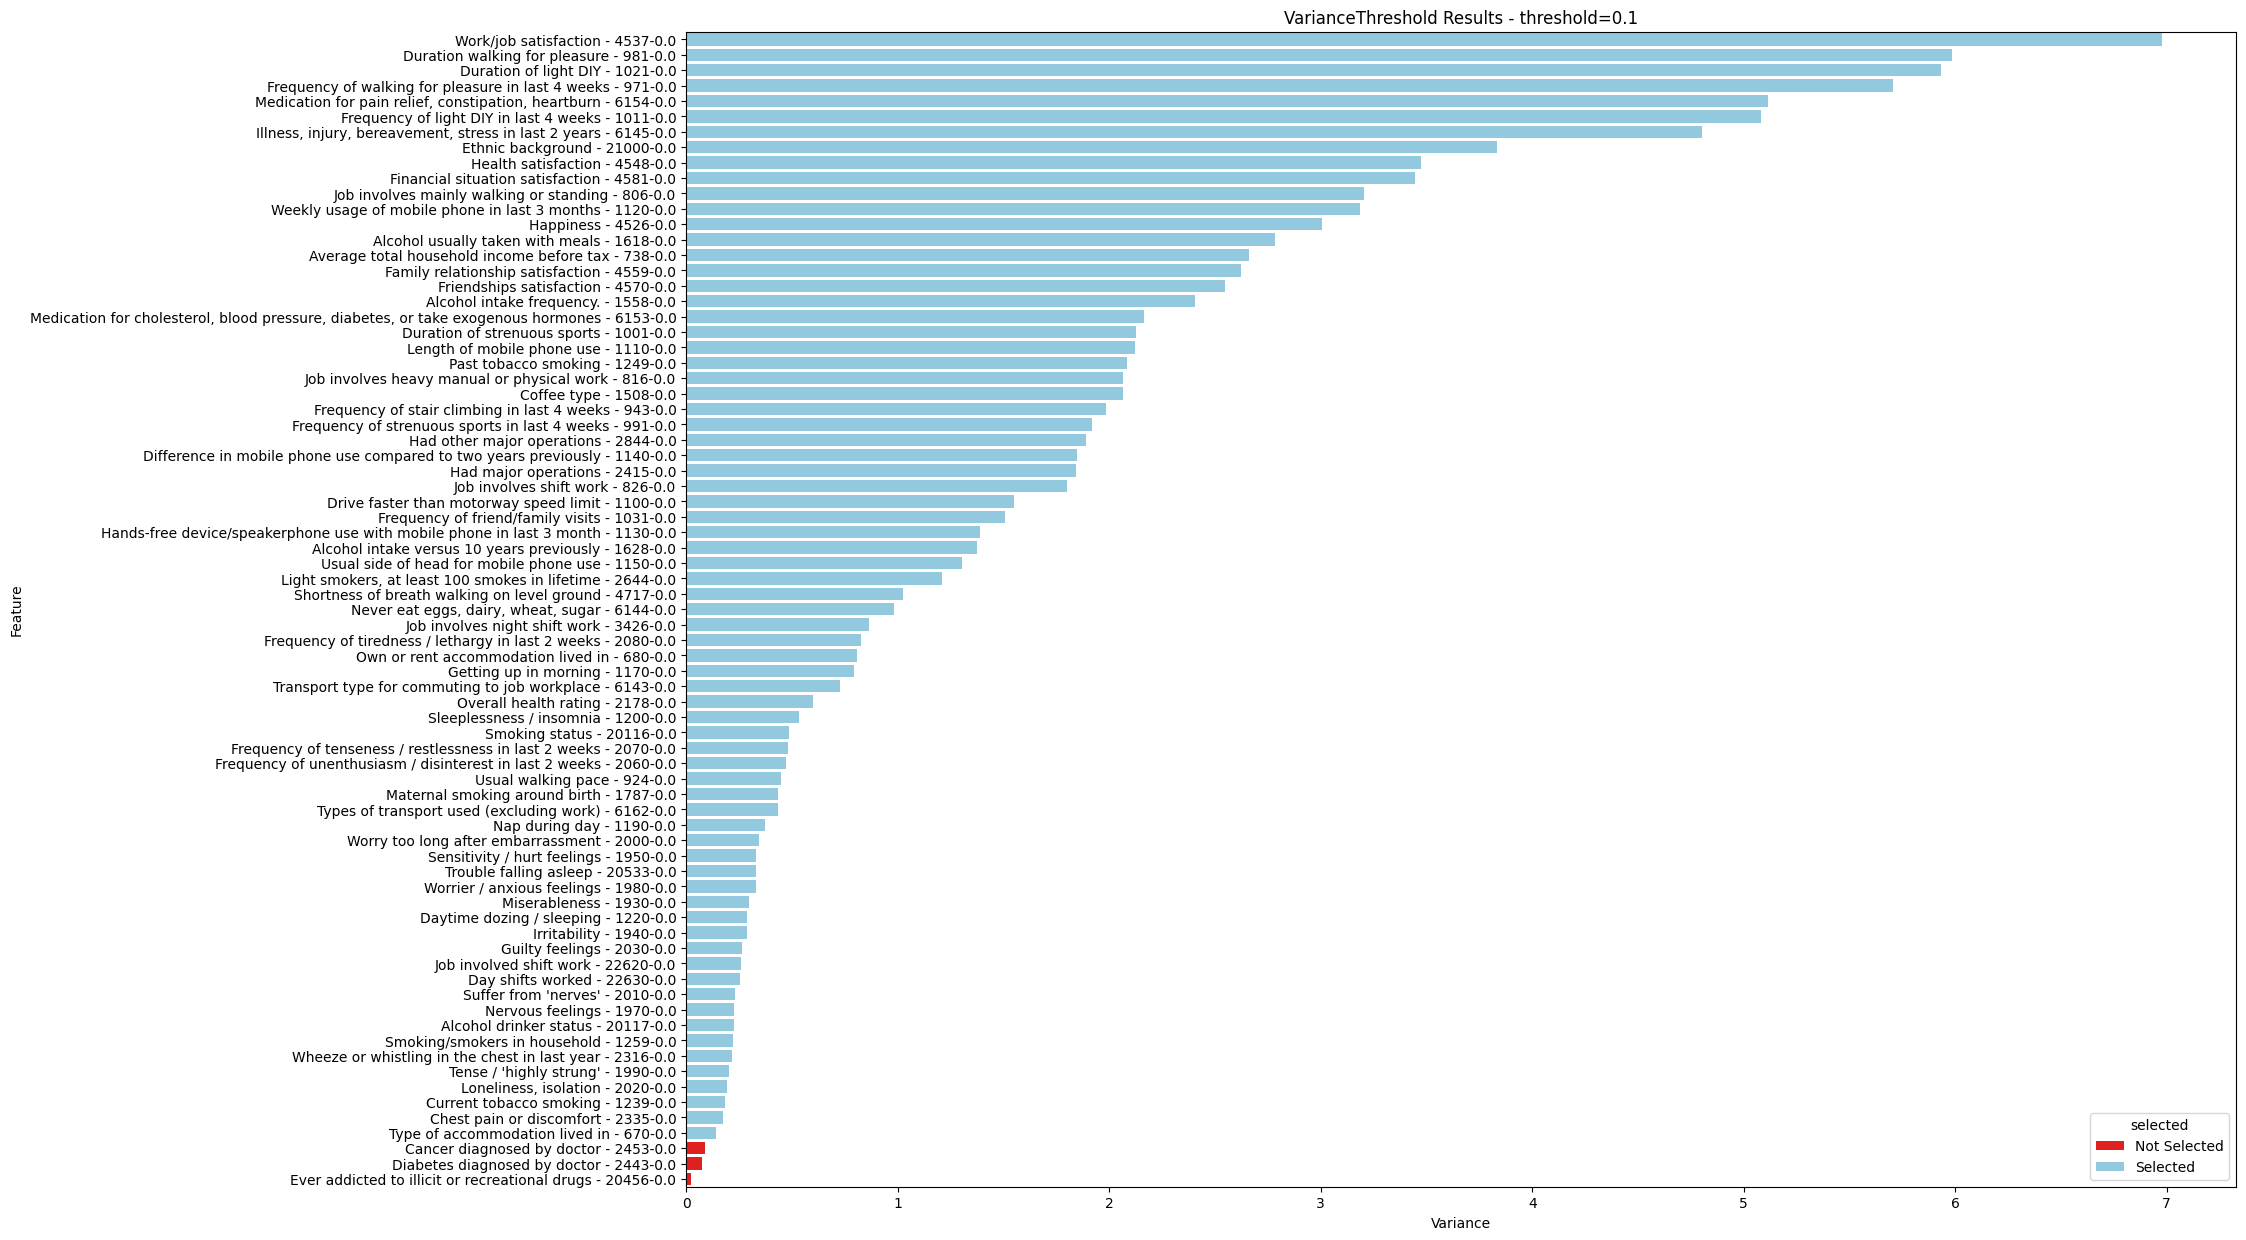

In [25]:
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns

threshold = 0.1
selector = VarianceThreshold(threshold=threshold)  # Adjust threshold as needed
X_new = selector.fit_transform(X_train_final, y_train)

# Get the selected feature indices
selected_features = X_train_final.columns[selector.get_support()]

# Get the scores for each feature
feature_variance = selector.variances_

# Create a DataFrame to view feature scores
feature_variance_df = pd.DataFrame({
    'Feature': X_train_final.columns,
    'Variance': selector.variances_,
    'selected': np.where(selector.get_support(), 'Selected', 'Not Selected')
})

feature_variance_df['Real Feature Name'] = feature_variance_df['Feature'].apply(convert_feature_code_to_name)

# Sort the DataFrame by score
feature_variance_df = feature_variance_df.sort_values(by='Variance', ascending=True)

top_features = feature_variance_df.head(100)

plt.figure(figsize=(20,15))
sns.barplot(x='Variance',y='Real Feature Name' ,
            hue='selected',
            data=feature_variance_df,
            legend=True,
            dodge=False,
            palette={
                'Selected': 'skyblue',
                'Not Selected': 'red'
            })
plt.xlabel('Variance')
plt.ylabel('Feature')
plt.title(f'VarianceThreshold Results - threshold={threshold}')
plt.gca().invert_yaxis()
plt.show()

### Linear Regression For Feature Importance to Categoric data

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder

In [27]:
encoder = OneHotEncoder(drop='first',
                        sparse_output=False)

X_train_encoded = pd.DataFrame(encoder.fit_transform(X_train_final, y_train),
                               columns=encoder.get_feature_names_out())

/home/omerkr@mta.ac.il/bioEnv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


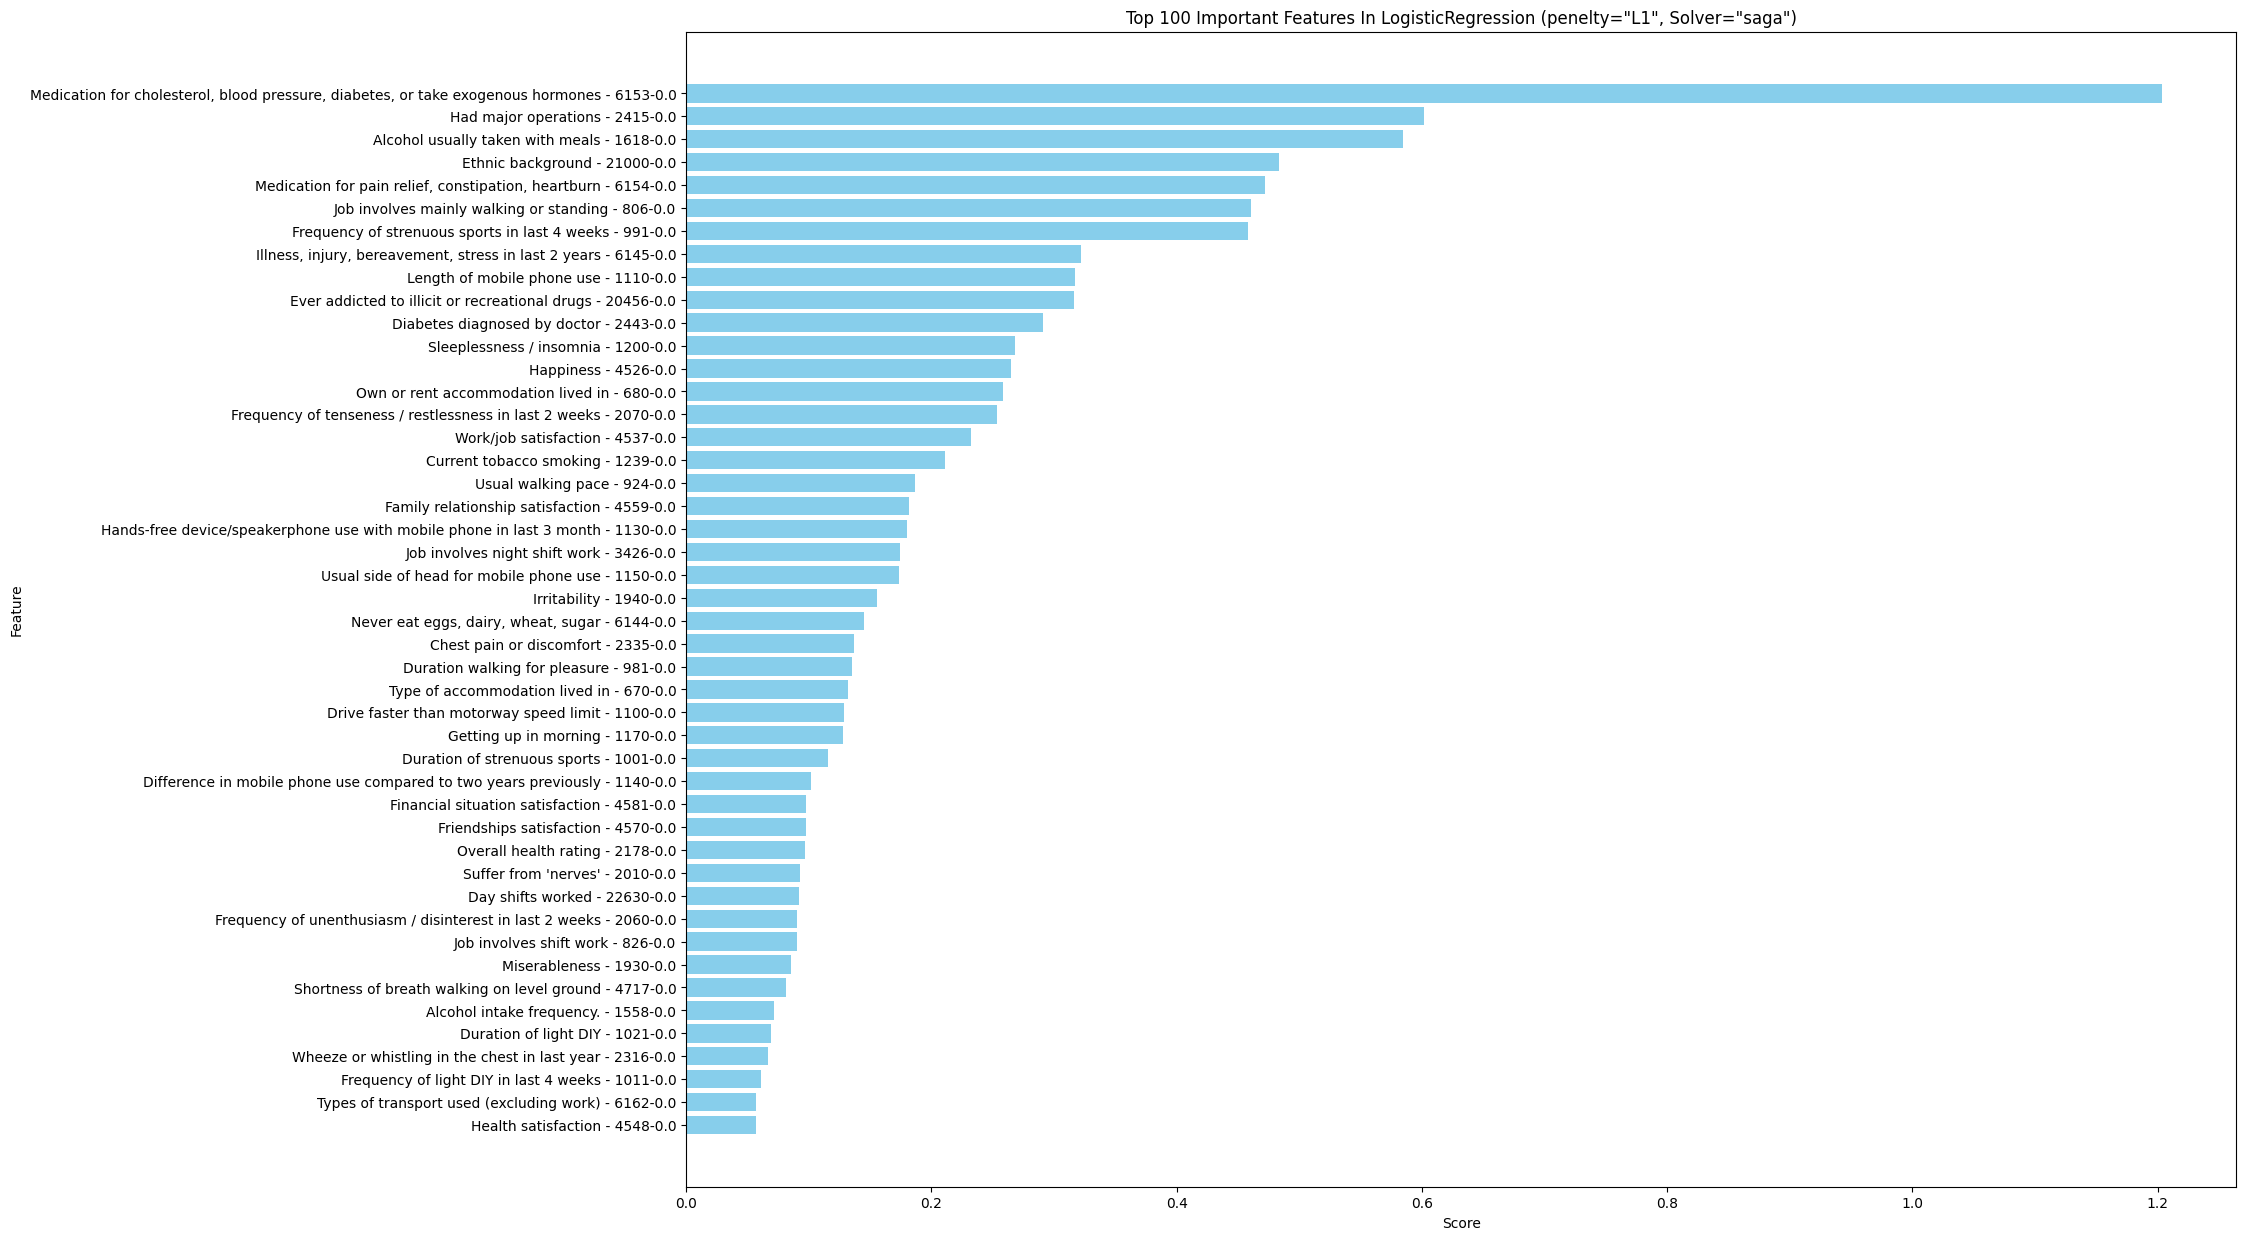

In [28]:

model = LogisticRegression(penalty='l1', solver='saga')
model.fit(X_train_encoded, y_train)

# Get feature importances
coefficients = model.coef_[0]

# Create a DataFrame to view feature scores
feature_scores_df = pd.DataFrame({
    'Feature': X_train_encoded.columns,
    'Score': coefficients
})

feature_scores_df['Real Feature Name'] = feature_scores_df['Feature'].apply(convert_feature_code_to_name)

# Sort the DataFrame by score
feature_scores_df = feature_scores_df.sort_values(by='Score', ascending=False)

Plot_barh_results(df=feature_scores_df,
                  y_axis_feature= 'Real Feature Name',
                  x_axis_feature= 'Score', 
                  k=100,
                  NameOfTesting='LogisticRegression (penelty="L1", Solver="saga")',
                  figsize=(20,15))

Accuracy Score: 0.9628551064046431


Classification Report: 
               precision    recall  f1-score   support

       No MI       0.97      0.99      0.98     47714
          MI       0.10      0.04      0.06      1391

    accuracy                           0.96     49105
   macro avg       0.54      0.51      0.52     49105
weighted avg       0.95      0.96      0.95     49105



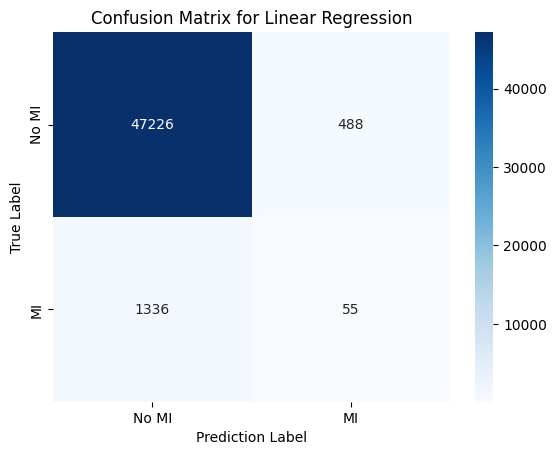

In [29]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_curve

X_validation_encoded = pd.DataFrame(encoder.transform(X_validation_final),
                                    columns=encoder.get_feature_names_out())

y_prediction = model.predict(X_validation_encoded)

# accuracy_score
accuracy = accuracy_score(y_true=y_validation,y_pred=y_prediction)

# confusion_matrix
cm = confusion_matrix(y_true=y_validation,y_pred=y_prediction)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No MI', 'MI'], yticklabels=['No MI', 'MI'])
plt.xlabel('Prediction Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Linear Regression')

# Classification Report
report = classification_report(y_true=y_validation, y_pred=y_prediction, target_names=['No MI', 'MI'] )

# Show results
print(f"Accuracy Score: {accuracy}")
print("\n\nClassification Report: \n", report)
plt.show()


### Recursive Feature Elimination with Random Forrest


In [30]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

n_features_to_select = 45
model = RandomForestClassifier()
rfe = RFE(model, n_features_to_select=n_features_to_select)
rfe = rfe.fit(X_train_final, y_train)

Plot Results

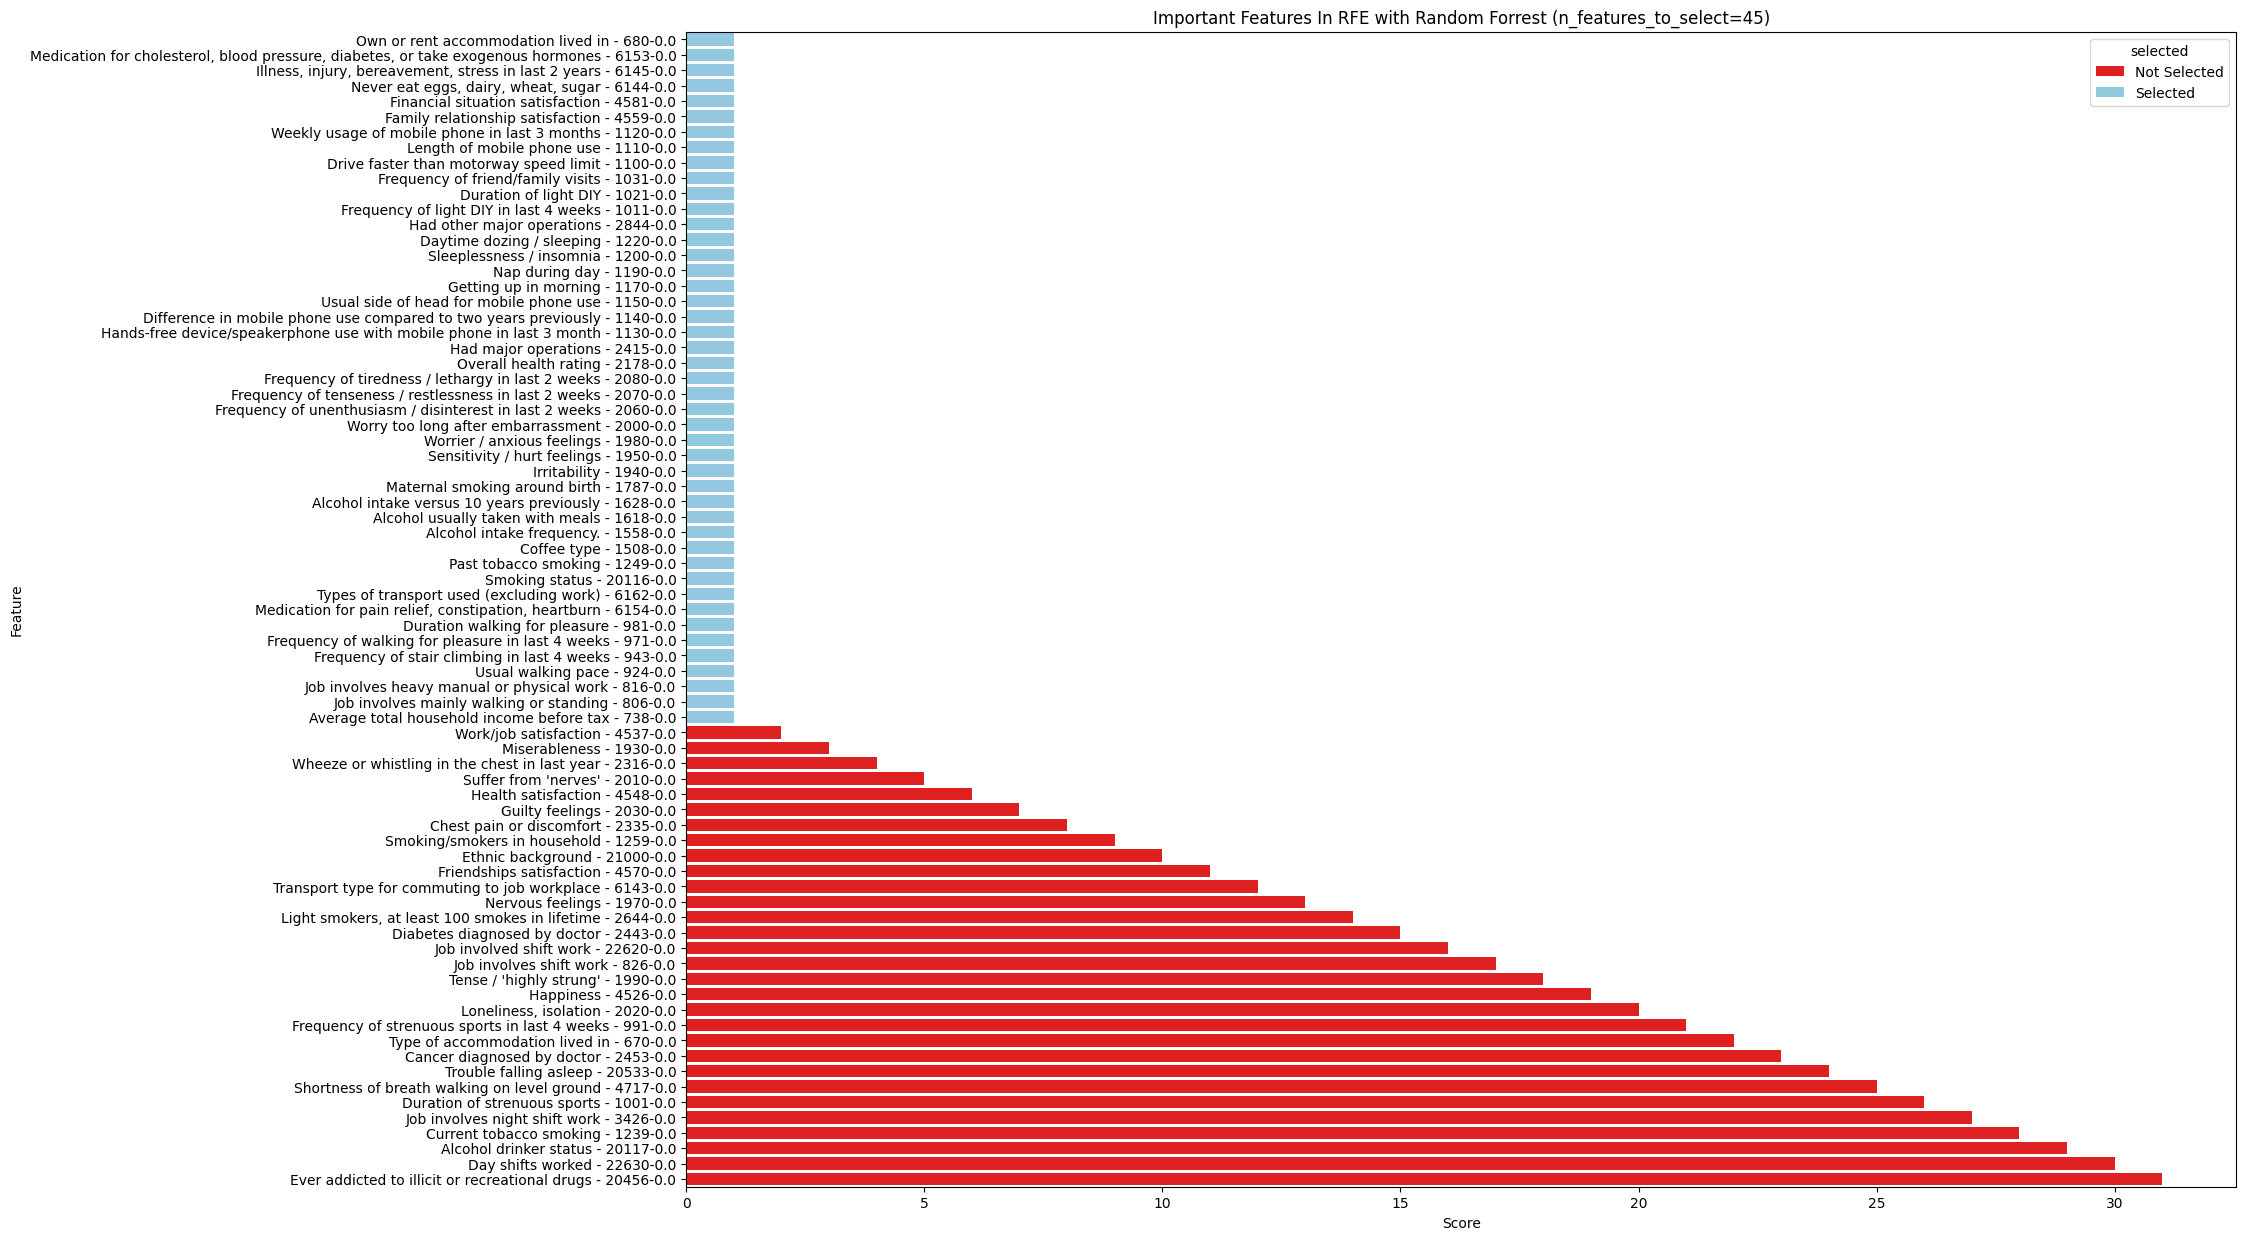

In [31]:
# Get the selected feature indices
selected_features = X_train_final.columns[rfe.support_]

# Get the scores for each feature
feature_importance = rfe.ranking_

# Create a DataFrame to view feature scores
feature_importance_df = pd.DataFrame({
    'Feature': X_train_final.columns,
    'Score': feature_importance,
    'selected': np.where(rfe.get_support(), 'Selected', 'Not Selected')
})

feature_importance_df['Real Feature Name'] = feature_importance_df['Feature'].apply(convert_feature_code_to_name)

# Sort the DataFrame by score
feature_importance_df = feature_importance_df.sort_values(by='Score', ascending=False)

top_features = feature_importance_df.head(100)

plt.figure(figsize=(20,15))
sns.barplot(x='Score',y='Real Feature Name' ,
            hue='selected',
            data=feature_importance_df,
            legend=True,
            dodge=False,
            palette={
                'Selected': 'skyblue',
                'Not Selected': 'red'
            })
plt.xlabel('Score')
plt.ylabel('Feature')
plt.title(f'Important Features In RFE with Random Forrest (n_features_to_select={n_features_to_select})')
plt.gca().invert_yaxis()
plt.show()

Accuracy Score: 0.9632420323795947


Classification Report: 
               precision    recall  f1-score   support

       No MI       0.97      0.99      0.98     47714
          MI       0.09      0.03      0.05      1391

    accuracy                           0.96     49105
   macro avg       0.53      0.51      0.51     49105
weighted avg       0.95      0.96      0.95     49105



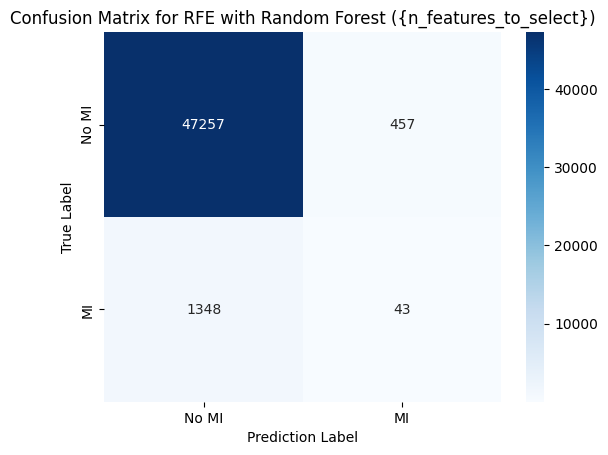

In [32]:

y_prediction = rfe.predict(X_validation_final)

# accuracy_score
accuracy = accuracy_score(y_true=y_validation,y_pred=y_prediction)

# confusion_matrix
cm = confusion_matrix(y_true=y_validation,y_pred=y_prediction)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No MI', 'MI'], yticklabels=['No MI', 'MI'])
plt.xlabel('Prediction Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for RFE with Random Forest ({n_features_to_select})')

# Classification Report
report = classification_report(y_true=y_validation, y_pred=y_prediction, target_names=['No MI', 'MI'] )

# Show results
print(f"Accuracy Score: {accuracy}")
print("\n\nClassification Report: \n", report)
plt.show()

### Run SHAP with CatBoost

In [33]:
from catboost import CatBoostClassifier
import shap

In [34]:
model = CatBoostClassifier(
    depth=6,
    learning_rate=0.1,
    iterations=100,
    loss_function='Logloss',
    cat_features=X_train_final.columns.to_list()
)

model.fit(X_train_final, y_train)

explainer = shap.Explainer(model)
shap_values = explainer(X_train_final)

RealFeatureNames = [convert_feature_code_to_name(code) for code in shap_values.feature_names]
shap_values.feature_names = RealFeatureNames

0:	learn: 0.6481500	total: 104ms	remaining: 10.3s
1:	learn: 0.6128984	total: 168ms	remaining: 8.22s
2:	learn: 0.5850396	total: 235ms	remaining: 7.61s
3:	learn: 0.5632755	total: 315ms	remaining: 7.56s
4:	learn: 0.5460390	total: 360ms	remaining: 6.84s
5:	learn: 0.5325670	total: 401ms	remaining: 6.29s
6:	learn: 0.5207082	total: 450ms	remaining: 5.98s
7:	learn: 0.5114410	total: 489ms	remaining: 5.62s
8:	learn: 0.5041156	total: 572ms	remaining: 5.78s
9:	learn: 0.4989781	total: 604ms	remaining: 5.44s
10:	learn: 0.4939385	total: 678ms	remaining: 5.48s
11:	learn: 0.4887120	total: 758ms	remaining: 5.56s
12:	learn: 0.4851081	total: 832ms	remaining: 5.57s
13:	learn: 0.4814069	total: 873ms	remaining: 5.36s
14:	learn: 0.4787880	total: 913ms	remaining: 5.17s
15:	learn: 0.4752175	total: 1.04s	remaining: 5.49s
16:	learn: 0.4716179	total: 1.1s	remaining: 5.39s
17:	learn: 0.4695582	total: 1.16s	remaining: 5.27s
18:	learn: 0.4667617	total: 1.21s	remaining: 5.16s
19:	learn: 0.4650420	total: 1.25s	remainin

/home/omerkr@mta.ac.il/bioEnv/lib/python3.10/site-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  pl.tight_layout()


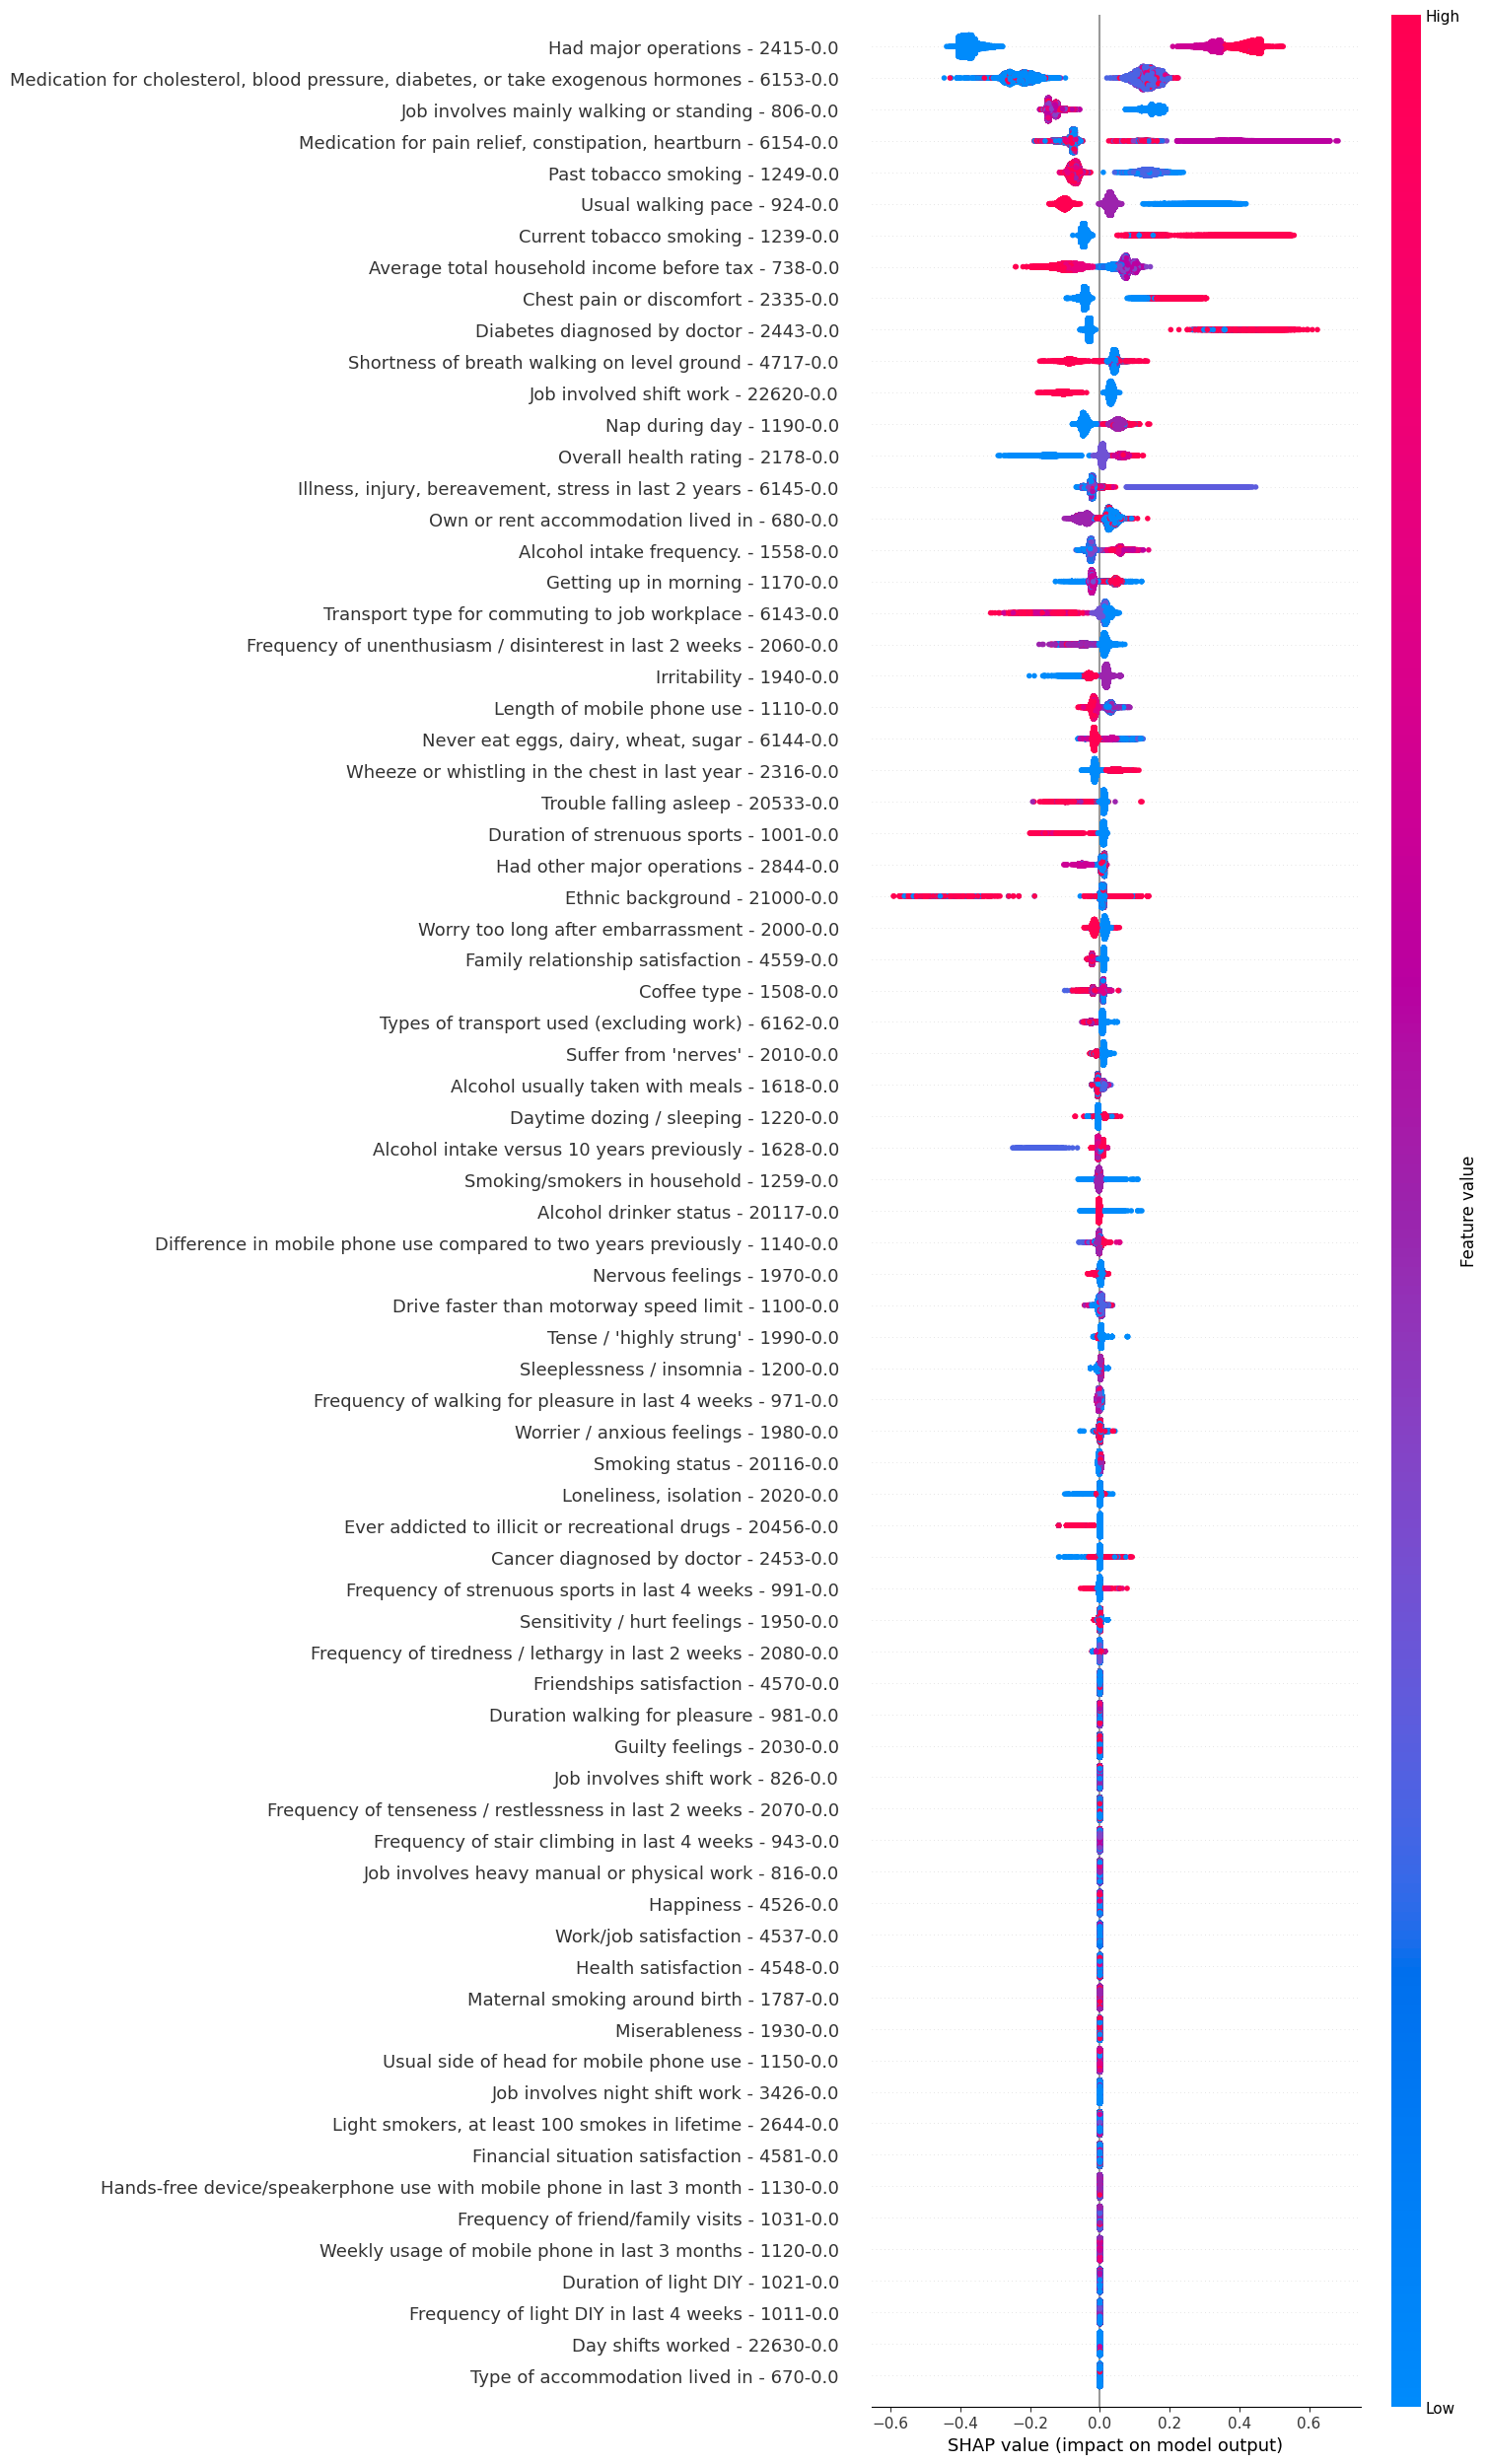

In [35]:
shap.summary_plot(shap_values,X_train_final,max_display=100)

In [36]:
## shap.force_plot(explainer.expected_value, shap_values.values, X_train_final)

Feature:  Job involves mainly walking or standing - 806-0.0


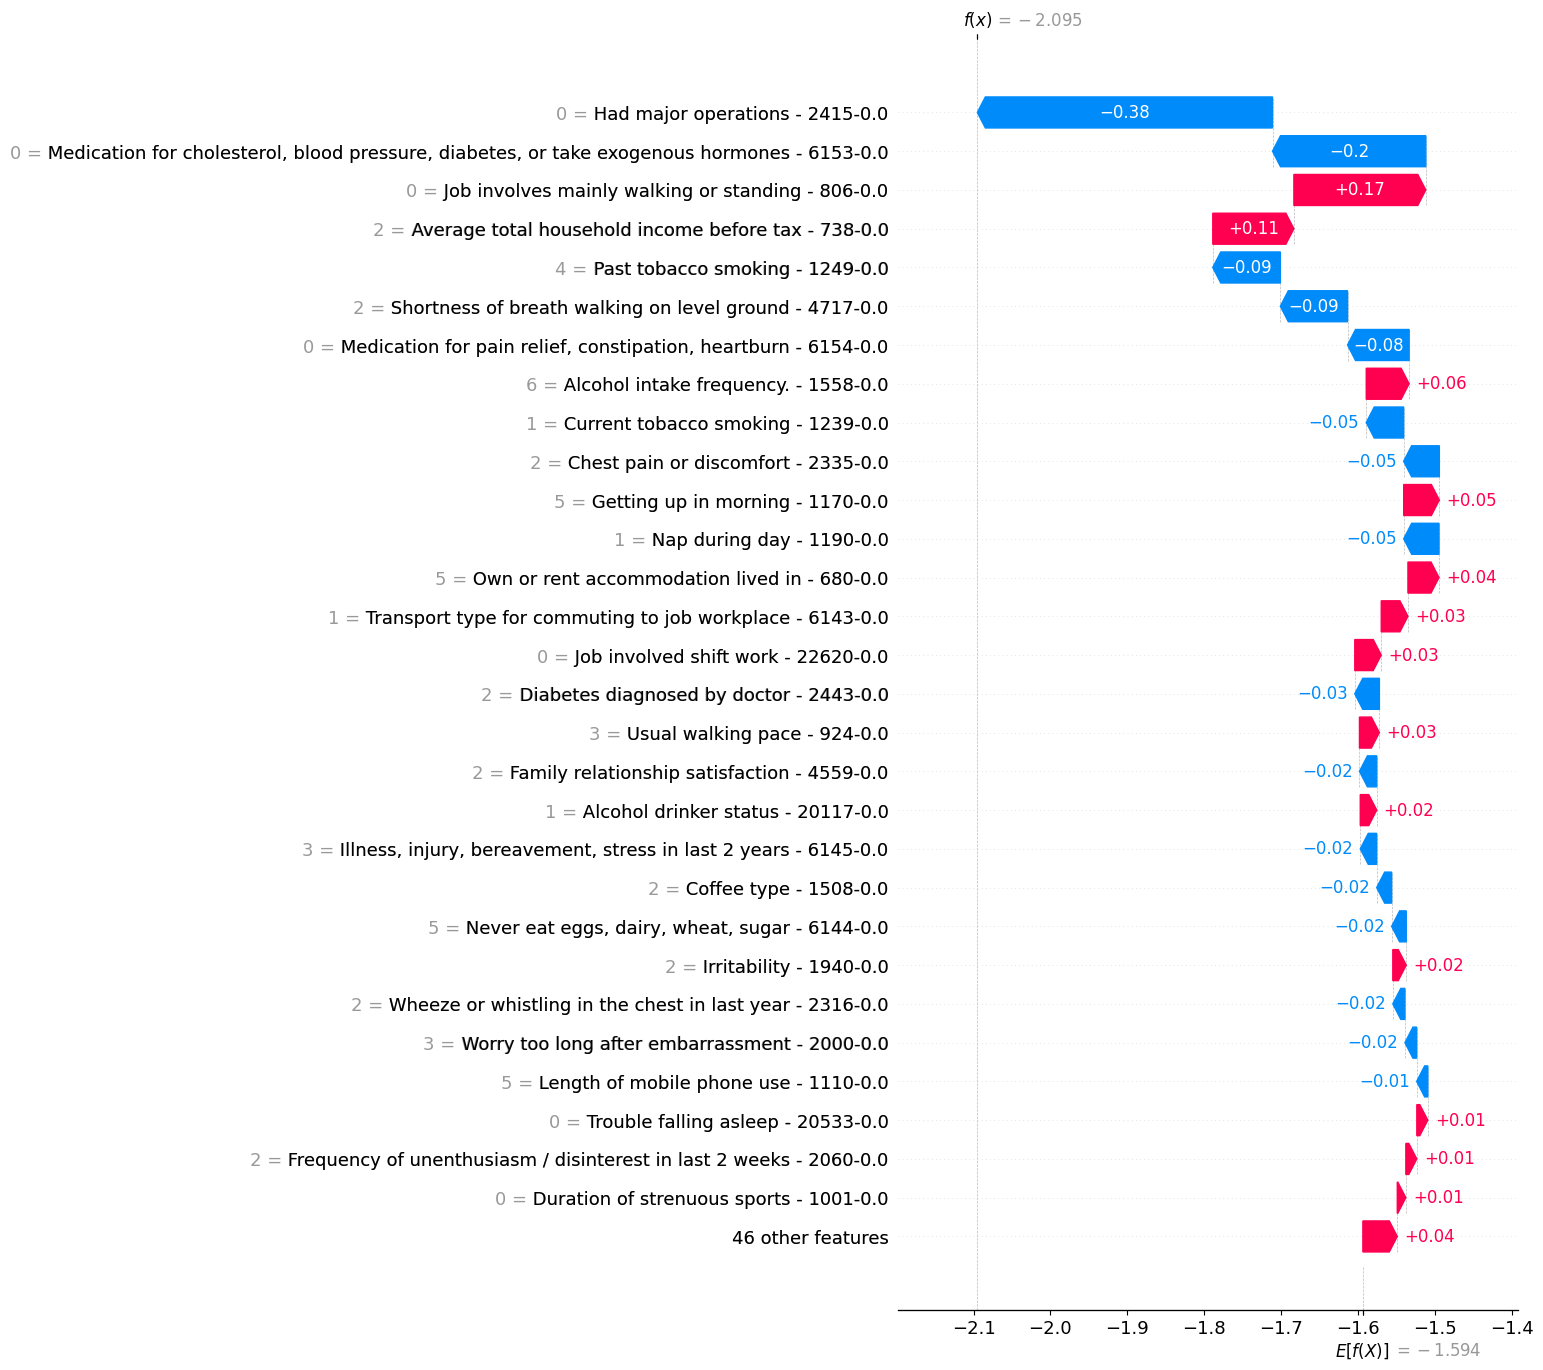

In [62]:
i = 3
print("Feature: ", shap_values.feature_names[i])
shap.waterfall_plot(shap_values[i],
                    max_display=30,
                    show=True)

In [38]:
require = False # For dont run it automatic when hit Run All Button
if require:
    shap.initjs()

    for i, feature_name in enumerate(shap_values.feature_names):
        print(f'')
        shap.waterfall_plot(shap_values[i],
                            max_display=30,
                            show=False
                            )
        plt.clf()

In [39]:
# shap.plots.heatmap(shap_values,
#                    max_display=10)

In [40]:
explainer_test = shap.TreeExplainer(model)
shap_values_test = explainer_test(X_train_final, y_train)

In [45]:
shap.initjs()

In [47]:
shap.plots.force(shap_values_test[0,...])

Accuracy Score: 0.9580490785052439
F1 Score: 0.0852575488454707


Classification Report: 
               precision    recall  f1-score   support

       No MI       0.97      0.98      0.98     47714
          MI       0.11      0.07      0.09      1391

    accuracy                           0.96     49105
   macro avg       0.54      0.53      0.53     49105
weighted avg       0.95      0.96      0.95     49105



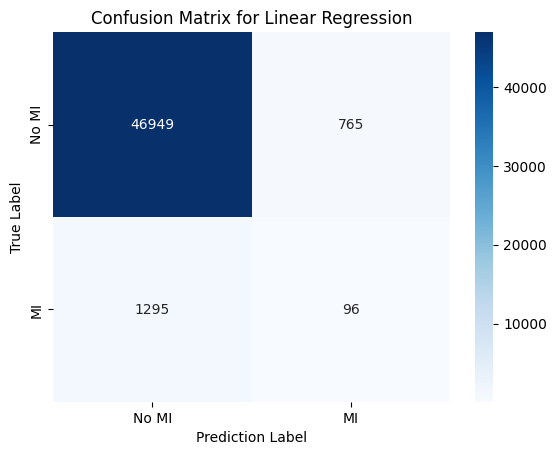

In [48]:
y_prediction = model.predict(X_validation_final)

# accuracy_score
accuracy = accuracy_score(y_true=y_validation,y_pred=y_prediction)

f1_score_res = f1_score(y_true=y_validation, y_pred=y_prediction)

# confusion_matrix
cm = confusion_matrix(y_true=y_validation,y_pred=y_prediction)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No MI', 'MI'], yticklabels=['No MI', 'MI'])
plt.xlabel('Prediction Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Linear Regression')

# Classification Report
report = classification_report(y_true=y_validation, y_pred=y_prediction, target_names=['No MI', 'MI'] )

# Show results
print(f"Accuracy Score: {accuracy}")
print(f"F1 Score: {f1_score_res}")
print("\n\nClassification Report: \n", report)
plt.show()